In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Data Pre-processing

In [2]:
df = pd.read_csv('train_test_small.csv.zip')

In [3]:
df['DEP_BLOCK'] = pd.Categorical(df.DEP_BLOCK).codes
df['CARRIER_NAME'] = pd.Categorical(df.CARRIER_NAME).codes
df['DEPARTING_AIRPORT'] = pd.Categorical(df.DEPARTING_AIRPORT).codes
df['PREVIOUS_AIRPORT'] = pd.Categorical(df.DEP_BLOCK).codes

In [4]:
idx = np.where( df.DEP_DEL15 == 0)[0]
df = df.drop(df.index[idx[:len(idx)//5*4]])
df.DEP_DEL15.value_counts()

1    87682
0    82876
Name: DEP_DEL15, dtype: int64

### Confusion Matrix 

<AxesSubplot:>

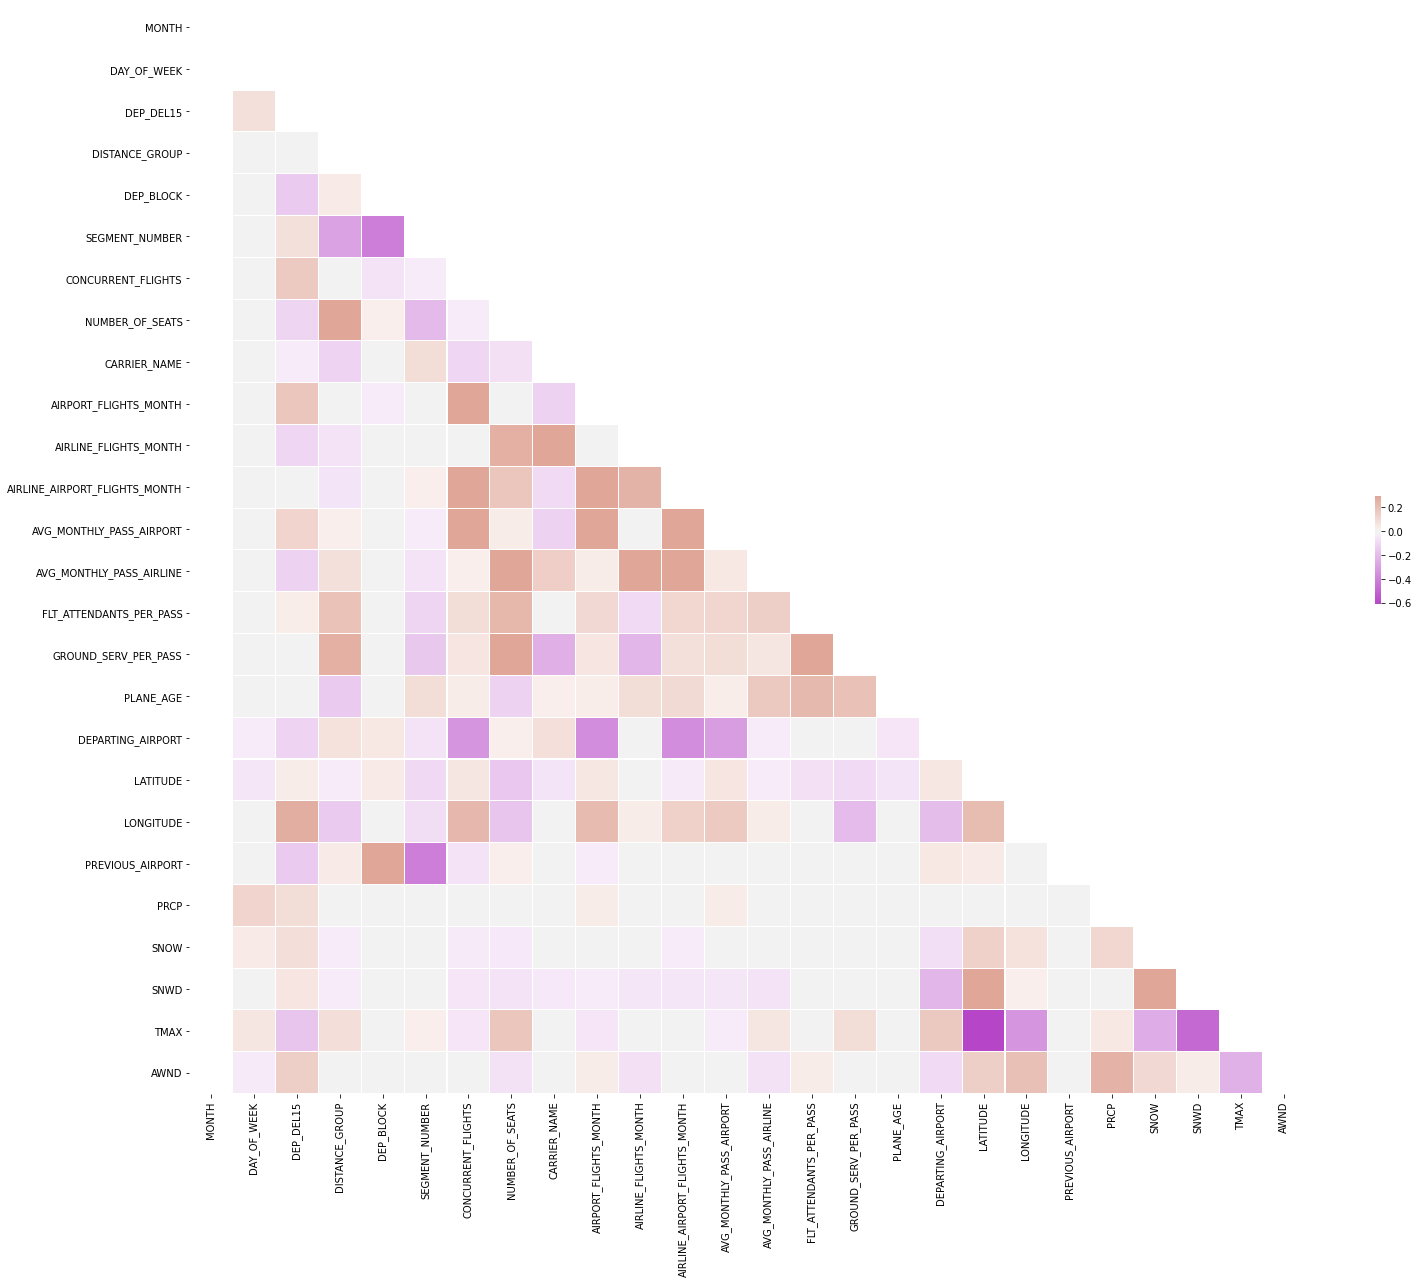

In [5]:
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(25, 20))
cmap = sns.diverging_palette(300, 20, as_cmap=True)


sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=0.1, cbar_kws={"shrink": .1}, ax = ax)

In [6]:
def histogram(data):
    fig, axs = plt.subplots(5,5,figsize=(30, 30) )
    columns = list(df.columns[:2])+list(df.columns[3:])
    for i in range(5):
        for j in range(5):
                axs[i,j].hist(data[columns[i*5+j]])
                axs[i,j].set_title(columns[i*5+j])      

In [7]:
cols = ['DAY_OF_WEEK', 'DISTANCE_GROUP', 'DEP_BLOCK','SEGMENT_NUMBER', 'CONCURRENT_FLIGHTS', 'NUMBER_OF_SEATS',
       'CARRIER_NAME', 'AIRPORT_FLIGHTS_MONTH', 'AIRLINE_FLIGHTS_MONTH', 'AIRLINE_AIRPORT_FLIGHTS_MONTH', 
       'AVG_MONTHLY_PASS_AIRPORT', 'AVG_MONTHLY_PASS_AIRLINE', 'FLT_ATTENDANTS_PER_PASS', 'GROUND_SERV_PER_PASS',
       'PLANE_AGE', 'DEPARTING_AIRPORT', 'LATITUDE', 'PREVIOUS_AIRPORT', 'PRCP', 'SNOW', 'SNWD', 'AWND']
def scale(data, columns):
    for col in columns:
        data[col] = np.log( data[col] + 1 )
scale(df,cols)

### Leave one - searching the most important features

In [5]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

columns = list(df.columns[1:2])+list(df.columns[3:])
for column in columns:
    
#     X = df.drop(['DEP_DEL15', column], axis=1)
    X = df[[column, 'MONTH']]
    y = df['DEP_DEL15']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    clf = xgb.XGBClassifier()
    clf.fit(X_train, y_train)
    
    print("\n\n\nWithout column: " + column)
    print("Train accuracy", clf.score(X_train, y_train))
    print("Test accuracy", clf.score(X_test, y_test))

/home/ali/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:46:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



Without column: DAY_OF_WEEK
Train accuracy 0.5565619175133234
Test accuracy 0.5543395220751532
[17:46:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



Without column: DISTANCE_GROUP
Train accuracy 0.546690819353653
Test accuracy 0.5444612241272098
[17:46:11] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.



Without column: DEP_BLOCK
Train accuracy 0.




Without column: AWND
Train accuracy 0.6114742765132621
Test accuracy 0.6130763080749756


### Models

In [28]:
from sklearn.model_selection import train_test_split

X = df.drop('DEP_DEL15', axis=1)
y = df['DEP_DEL15']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


# # Tried but useless

from sklearn.preprocessing import StandardScaler, normalize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.fit_transform(X_test)

# X_train = normalize(X_train, norm='l2')
# X_test  = normalize(X_test, norm='l2')


In [135]:
# Random forest
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
print("Train accuracy", clf.score(X_train, y_train))
print("Test accuracy", clf.score(X_test, y_test))

Train accuracy 0.6648202112485014
Test accuracy 0.663747001865506


In [13]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
print("Train accuracy", clf.score(X_train, y_train))
print("Test accuracy", clf.score(X_test, y_test))

/home/ali/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:55:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Train accuracy 0.9107313188592231
Test accuracy 0.9027449586923691


In [161]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier()
clf.fit(X_train, y_train, verbose=False)
print("Train accuracy", clf.score(X_train, y_train))
print("Test accuracy", clf.score(X_test, y_test))

Train accuracy 0.909331163091894
Test accuracy 0.8939148973971751


In [42]:
y_train_pred = clf.predict_proba(X_train)
y_test_pred = clf.predict_proba(X_test)

### Deep Learning

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time
import pickle
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#### AutoML

In [17]:
LOG_DIR = f"{int(time.time())}"

# tensorboard = TensorBoard(log_dir=LOG_DIR)

def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Dense(hp.Int('input_units',min_value=50, max_value=200, step=50), 
                    input_shape=X_train.shape[1:],
                    activation='relu'))

    model.add( Dropout(hp.Float('dropout_rate',
                                    min_value=0.0,
                                    max_value=0.5,
                                    step=0.1) ) )
    
    for i in range(hp.Int('n_layers', 1, 2)):  # adding variation of layers.
        model.add(Dense(hp.Int(f'layer_{i}_units',
                                min_value=10,
                                max_value=150,
                                step=30), 
                                activation='relu'))
    
        model.add( Dropout(hp.Float(f'dropout_{i}_rate',
                                    min_value=0.0,
                                    max_value=0.5,
                                    step=0.1) ) )
    
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
              
    return model
                  

tuner = RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=10,  # how many variations on model?
    executions_per_trial=1) # how many trials per variation? (same model could perform differently)


tuner.search_space_summary()

tuner.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size=64)

tuner.results_summary()

Trial 10 Complete [00h 00m 08s]
accuracy: 0.8135780096054077

Best accuracy So Far: 0.8550663590431213
Total elapsed time: 00h 01m 18s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='accuracy', direction='max')
Trial summary
Hyperparameters:
input_units: 200
dropout_rate: 0.0
n_layers: 1
layer_0_units: 100
dropout_0_rate: 0.1
layer_1_units: 70
dropout_1_rate: 0.4
Score: 0.8550663590431213
Trial summary
Hyperparameters:
input_units: 100
dropout_rate: 0.0
n_layers: 2
layer_0_units: 130
dropout_0_rate: 0.4
layer_1_units: 70
dropout_1_rate: 0.2
Score: 0.8412923216819763
Trial summary
Hyperparameters:
input_units: 150
dropout_rate: 0.1
n_layers: 1
layer_0_units: 130
dropout_0_rate: 0.1
layer_1_units: 40
dropout_1_rate: 0.0
Score: 0.8347728848457336
Trial summary
Hyperparameters:
input_units: 200
dropout_rate: 0.1
n_layers: 1
layer_0_units: 70
dropout_0_rate: 0.1
layer_1_units: 130
dropout_1_rate: 0.4
Score: 0.8337665

#### DL model

In [20]:
def build_model():  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()

    model.add(Dense(200, input_shape=X_train.shape[1:], activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add( Dropout( 0.1 ) )
    model.add(Dense(70, activation='relu'))
    model.add( Dropout( 0.4 ) )
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', 
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics =['accuracy'])
              
    return model
                  

model = build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, verbose=1)
reducer = tf.keras.callbacks.ReduceLROnPlateau( monitor='loss', factor=0.5, patience=3, verbose=1, mode='min')


model.fit(X_train,y_train, callbacks=[early_stopping, reducer], batch_size=256,verbose=1,epochs=1000 )

y_test = model.predict(X_test)

Epoch 1/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.5198 - accuracy: 0.7303
Epoch 2/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.4374 - accuracy: 0.7861
Epoch 3/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.3981 - accuracy: 0.8124
Epoch 4/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.3701 - accuracy: 0.8298
Epoch 5/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.3499 - accuracy: 0.8423
Epoch 6/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.3341 - accuracy: 0.8524
Epoch 7/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.3211 - accuracy: 0.8594
Epoch 8/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.3130 - accuracy: 0.8644
Epoch 9/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.3052 - accuracy: 0.8685
Epoch 10/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.298

447/447 [==============================] - 1s 1ms/step - loss: 0.2155 - accuracy: 0.9119
Epoch 80/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2149 - accuracy: 0.9127
Epoch 81/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2147 - accuracy: 0.9124
Epoch 82/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2150 - accuracy: 0.9122
Epoch 83/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2138 - accuracy: 0.9123
Epoch 84/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2143 - accuracy: 0.9128
Epoch 85/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2137 - accuracy: 0.9126
Epoch 86/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2132 - accuracy: 0.9130
Epoch 87/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2130 - accuracy: 0.9134
Epoch 88/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.2131 - a

447/447 [==============================] - 1s 2ms/step - loss: 0.1851 - accuracy: 0.9240
Epoch 155/1000
447/447 [==============================] - 1s 1ms/step - loss: 0.1845 - accuracy: 0.9249
Epoch 156/1000
447/447 [==============================] - 1s 2ms/step - loss: 0.1849 - accuracy: 0.9248
Epoch 157/1000
447/447 [==============================] - 1s 2ms/step - loss: 0.1844 - accuracy: 0.9244
Epoch 158/1000
447/447 [==============================] - 1s 2ms/step - loss: 0.1842 - accuracy: 0.9244
Epoch 159/1000
447/447 [==============================] - 1s 2ms/step - loss: 0.1855 - accuracy: 0.9247
Epoch 160/1000
447/447 [==============================] - 1s 2ms/step - loss: 0.1849 - accuracy: 0.9251
Epoch 161/1000
422/447 [===========================>..] - ETA: 0s - loss: 0.1841 - accuracy: 0.9249
Epoch 00161: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
447/447 [==============================] - 1s 2ms/step - loss: 0.1846 - accuracy: 0.9248
Epoch 162/1000
447/

In [30]:
import sklearn
from sklearn.metrics import accuracy_score 
y_hat = model.predict_classes(X_test)
# y_test
print("Test accuracy", sklearn.metrics.accuracy_score(y_test, y_hat))

Test accuracy 0.8993692813360575


### Confusion Matrix

In [14]:
from sklearn.metrics import confusion_matrix
y_hat = clf.predict(X_test)
confusion_matrix(y_test, y_hat)


NameError: name 'clf' is not defined

### Precision Recall Curve


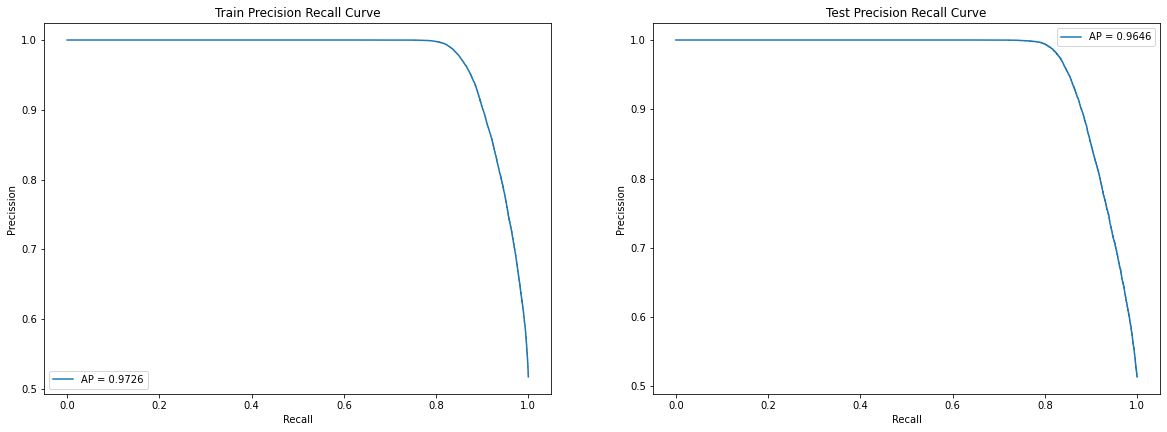

In [43]:
from sklearn.metrics import precision_recall_curve, average_precision_score
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_pred[:,1])
train_ap = average_precision_score(y_train, y_train_pred[:,1])

test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pred[:,1])
test_ap = average_precision_score(y_test, y_test_pred[:,1])


plt.figure(figsize=(20, 15))

axs = plt.subplot(2,2,1)
axs.set_title('Train Precision Recall Curve')
axs.set_xlabel('Recall')
axs.set_ylabel('Precission')
axs.plot(train_recall, train_precision, label = 'AP = {:.4f}'.format(train_ap))
axs.legend()

axs = plt.subplot(2,2,2)
axs.set_title('Test Precision Recall Curve')
axs.set_xlabel('Recall')
axs.set_ylabel('Precission')
axs.plot(test_recall, test_precision, label = 'AP = {:.4f}'.format(test_ap))
axs.legend()

### ROC curve

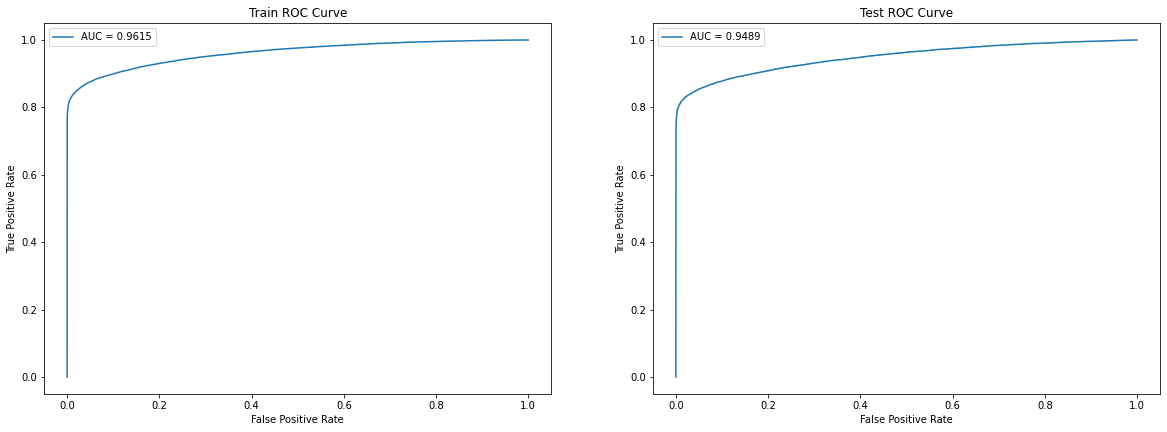

In [44]:
from sklearn.metrics import roc_curve, auc
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_pred[:,1])
train_auc = auc(train_fpr, train_tpr)

test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred[:,1])
test_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(20, 15))

axs = plt.subplot(2,2,1)
axs.set_title('Train ROC Curve')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.plot(train_fpr, train_tpr, label = 'AUC = {:.4f}'.format(train_auc))
axs.legend()

axs = plt.subplot(2,2,2)
axs.set_title('Test ROC Curve')
axs.set_xlabel('False Positive Rate')
axs.set_ylabel('True Positive Rate')
axs.plot(test_fpr, test_tpr, label = 'AUC = {:.4f}'.format(test_auc))
axs.legend()